# Training and evaluating VAEs with MNIST data.

*"Auto-Encoding Variational Bayes" by Diederik P. Kingma and Max Welling (2013).*


**Variational Autoencoders** (VAEs) are a powerful and versatile **deep learning technique**. Applied to the MNIST dataset, VAEs learn to generate new **handwritten digit image**s. They work by **encoding** each 28x28 pixel image into a smaller, compressed representation called a **latent space**. This latent space captures the essential features of the digits, like the overall shape and style. From this compressed representation, the VAE can then **decode and reconstruct** the image, generating new variations of handwritten digits similar to those it was trained on. This process allows VAEs to not only reproduce existing digits but also create entirely new ones that maintain the characteristics of the MNIST dataset, effectively learning the underlying distribution of handwritten digits.

Factors that make VAEs a relatively "advanced" technique:
1. **Probabilistic Nature:** VAEs are built on a probabilistic framework, modeling the data distribution and using variational inference. This adds complexity but also allows for generating new data.   
2. **Reparameterization Trick:** This clever technique makes it possible to train VAEs using backpropagation despite the stochastic sampling involved.  
3. **Latent Space Representation:** VAEs learn a meaningful latent space that captures the underlying structure of the data. This latent space can be used for various tasks like generating new data, interpolating between data points, and anomaly detection.  

Load all packages, select the device to be GPU, if GPU non-avaliable, use CPU instead.

In [280]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used is", device)

Device used is cpu


## Load and prepare data.

Download the train data. The MNIST dataset contains 60,000 images in the train dataset. Reduce this to 20,000 by sampling 2,000 randomly for each digit 0-9. NB: variable 'samples' specifies the number of samples per class. If not using data augmentation (see below), you can reduce to probably 1,000 samples per label. This will speed up training.



In [281]:
train_set = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())

x_train = train_set.data.numpy()
y_train = train_set.targets.numpy()

print('Train set shape:', x_train.shape)
print('Train labels shape:', y_train.shape)


Train set shape: (60000, 28, 28)
Train labels shape: (60000,)


In [282]:
# Choose the number of samples to generate for each digit 0-9
samples = 2000

count     = np.zeros(10)  # Counters for samples per class 0-9
indices   = []            # Store indices of the selected samples

for i in range(len(y_train)):
    label = y_train[i]
    if count[label] < samples:  # Keep adding samples until count reaches 'samples' for each class
        indices.append(i)
        count[label] += 1

# Convert list of indices to numpy array
indices = np.array(indices)

# Select the samples based on filtered indices
x_train     = x_train[indices]
y_train     = y_train[indices]

Download the test data. For test data, only use a random sample of 2,000 images. NB: variable 'samples' from above specifies the number of samples per class.

In [283]:
test_set  = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())

indices = np.random.choice(len(test_set), size=samples, replace=False)

# Get the data  labels at the random indices
x_test = test_set.data[indices].numpy()
y_test = test_set.targets[indices].numpy()

print('Test set, shape:', x_test.shape)
print('Test labels shape:', y_test.shape)

Test set, shape: (2000, 28, 28)
Test labels shape: (2000,)


### Resize the images from 28x28 to 14x14 (optional, recommended).

Reasons for resizing the images for VAE training:

1. Reduced Dimensionality: This can make the learning task easier for the VAE, especially when dealing with limited computational resources.

2. Focus on Essential Features: It forces the model to extract the most salient features of the digits, ignoring less important details. This can lead to a more robust and generalizable model.

3. Latent Space Efficiency: Downsampling can help create a more compact and meaningful latent space, making it easier to generate new images and explore variations within the data.

4. Reduce Overfitting: With fewer dimensions, there's less chance of the VAE overfitting to the training data.

In [284]:
# NB: you can skip resizing entirely. To do so, simply comment out the code in this field.

x_train_p = x_train
x_test_p  = x_test

# Train data
# Initialize array to hold resized images
x_train = np.zeros((x_train_p.shape[0], 14, 14))
for i in range(x_train_p.shape[0]):
  # Resizing the image from 28x28 to 14x14
  x_train[i] = cv2.resize(x_train_p[i].astype('float32'), (14,14))

# Test data, repeat
x_test = np.zeros((x_test_p.shape[0], 14, 14))
for i in range(x_test_p.shape[0]):
    x_test[i] = cv2.resize(x_test_p[i].astype('float32'), (14, 14))

### Binarize the data (optional, recommended).
Binarizing data means converting pixel values to either 0 (black) or 1 (white). This can be useful for our VAE because it:

1. Simplifies the data, thus reducing complexity and noise.

2. Improves model robustness by ensuring invariance to intensity variation and forcing the model to focus on shape.

3. Achieves computational efficiency by reducing memory usage and potentially leading to faster performance.

In image data, pixel values are often represented as integers ranging from 0 (black)  to 255 (white). 128 is the midpoint of this range. By using 128 as the threshold, we essentially divide the pixel values into two categories -- black and white.

  

In [285]:
# NB: you can skip binarizing entirely. To do so, simply comment out the code in this field.

x_train = np.where(x_train > 128, 1.0, 0.0).astype(np.float32)
x_test  = np.where(x_test > 128, 1.0, 0.0).astype(np.float32)

### Augment the data (optional, recommended but slows down training).

Data augmentation is very useful in machine learning, particularly for image recognition tasks. Here's why:

1. Increased Dataset Diversity.
2. Improved Model Robustness.
3. Reduced Overfitting.

In this implementation, we implement data augmentation by rotating some images randomly by 90 degrees.

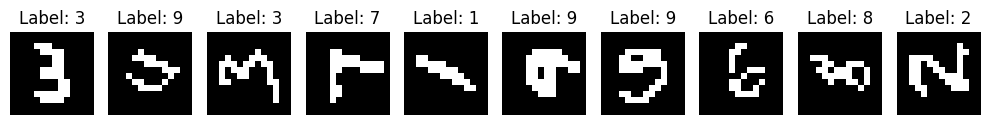

In [300]:
num_samples = 10  # Number of digits to visualize

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))

for i in range(num_samples):
  # Select a random digit
  index = np.random.randint(0, len(x_train))
  digit = x_train[index]
  label = y_train[index]

  # Apply a random rotation (0 or 90 degrees)
  k = np.random.randint(0, 1)
  rotated_digit = np.rot90(digit, k=k)

  # Display the rotated digit
  axes[i].imshow(rotated_digit, cmap='gray')
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


Rotate both train and test data randomly by 90 degress.

In [287]:
# Train data
x_train_p = x_train
x_train   = []
for x in x_train_p:
  a = random.randint(0,1)
  if a == 1:
    # Random rotation angle
    # k = random.randint(0, 3)
    x_train.append(np.rot90(x, k=1, axes=(0, 1)))
  else:
    x_train.append(x)

x_train = np.array(x_train)

# Test data
x_test_p = x_test
x_test = []
for x in x_test_p:
  a = random.randint(0,1)
  if a == 1:
    # Random rotation angle
    # k = random.randint(0, 3)
    x_test.append(np.rot90(x, k=1, axes=(0, 1)))
  else:
    x_test.append(x)

x_test = np.array(x_test)

### Create Dataloaders for train and test data.

Dataloaders ensure that the data is properly formatted, batched, and shuffled for efficient and effective training and evaluation.

For training, use reshuffle and try a batch size of 32. Yoshua Bengio's "Practical recommendations for gradient-based training of deep architectures" (2012) recommends using small batch sizes (between 2 and 32) for optimal generalization performance. change depending on performance.
  

In [288]:
# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
test_dataset  = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))

# Create DataLoaders
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
testloader  = DataLoader(test_dataset, shuffle=True, batch_size=100)

# Image size (default 14x14=196 unless resizing is omitted or modified)
image_length = len(x_train[0])
image_size   = image_length**2

## Define and train a VAE.

In [289]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder: fully connected linear layers [nn.Linear(input_size, output_size)]
        self.fc1  = nn.Linear(image_size, 128)  # Flattened 14x14 image mapped onto a hidden representation of size 128 (arbitrary, power of 2).
        self.fc21 = nn.Linear(128, 8)   # Maps the hidden representation to an 8-dimensional mean vector (mu).
        self.fc22 = nn.Linear(128, 8)   # Maps the hidden representation to an 8-dimensional log-variance vector (log_var).

        # Decoder: fully connected linear layers [nn.Linear(input_size, output_size)]
        self.fc3  = nn.Linear(8, 128)    # Maps the 8-dimensional latent space vector (z) to a hidden representation of size 128.
        self.fc4  = nn.Linear(128, image_size)  # Maps the hidden representation back to the original input size (196).

    def encoder(self, x):
        # Passes the input (x) through the (fc1).
        # Applies the hyperbolic tangent activation function.
        h = torch.tanh(self.fc1(x))

        # Calculates the mean (fc21) and log-variance (fc22) from the hidden representation (h).
        mu      = self.fc21(h)
        log_var = self.fc22(h)

        return mu, log_var # Having log-variance is nice for numerical stability.

    # This method implements the "reparameterization trick."
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Standard deviation = exp(0.5 x log_variance).
        eps = torch.randn_like(std)     # Generates a random tensor (eps) from a standard normal distribution with the same shape as (std).

        return mu + eps * std           # Reparameterization trick, returns (z), allows us to sample from the latent space in a differentiable way.

    def decoder(self, z):
        # Passes the latent vector (z) through (fc3).
        # Applies the hyperbolic tangent activation function.
        h = torch.tanh(self.fc3(z))

        # Passes the hidden representation (h) through (fc4)
        # and applies the sigmoid activation function to ensure the output is
        # in the range [0, 1], suitable for representing pixel values.
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        # Flattens the input (x) and passes it through the encoder to get (mu) and (log_var).
        # -1 in .view() tells PyTorch to autimatically inferthe dimension size based on
        # original tenzor's size, 196 is the 14x14 flattened.
        mu, log_var = self.encoder(x.view(-1, image_size))

        # Sample latent vector (z) using reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Pass through decoder to reconstruct input
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var

### Conditional VAE (bonus).

A CVAE allows you to generate digits conditionally. You provide a label (e.g., "generate a 5") as an input to the model, and it will try to generate an image of that specific digit.  

Unlike for VAE, both the encoder and decoder of a CVAE receive the label information. This guides the encoding and decoding processes to focus on the features relevant to the given label.

In [290]:
class CVAE(nn.Module):
    def __init__(self, num_classes=10):
        super(CVAE, self).__init__()

        # Encoder: fully connected linear layers [nn.Linear(input_size, output_size)]
        self.fc1  = nn.Linear(image_size+num_classes, 128)  # Flattened 14x14 image +10 labels for 0-9 mapped onto a hidden representation of size 128 (arbitrary, power of 2).
        self.fc21 = nn.Linear(128, 8)
        self.fc22 = nn.Linear(128, 8)

        # Decoder: fully connected linear layers [nn.Linear(input_size, output_size)]
        self.fc3  = nn.Linear(8+num_classes, 128)    # Maps the 8-dimensional latent space vector (z) +10 labels to a hidden representation of size 128.
        self.fc4  = nn.Linear(128, image_size)

    def encoder(self, x, labels):
        # Concatenates the input vector (x) with labels.
        x = torch.cat([x, labels], dim=1)
        # Passes (x) through the (fc1).
        h = torch.tanh(self.fc1(x))

        mu      = self.fc21(h)
        log_var = self.fc22(h)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def decoder(self, z, labels):
        # Concatenates the latent vector (z) with labels.
        z = torch.cat([z, labels], dim=1)
        # Passes the latent vector (z) through (fc3).
        h = torch.tanh(self.fc3(z))

        return torch.sigmoid(self.fc4(h))

    def forward(self, x, labels):
        # Flattens the input (x) and joins it with labels
        mu, log_var = self.encoder(x.view(-1, image_size), labels)
        z = self.reparameterize(mu, log_var)

        return self.decoder(z,labels), mu, log_var

### Choose and initialise the model.
Set preference to 1 to use CVAE. Select the device to be GPU if available, else use CPU.

In [291]:
preference = 1 # if 1 CVAE else VAE

# Instantiate the model
if preference == 1:
  model = CVAE()
else:
  model = VAE()

# Check if CUDA is available and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move the model to the chosen device (cuda or cpu)
model.to(device)

CVAE(
  (fc1): Linear(in_features=206, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=8, bias=True)
  (fc22): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=196, bias=True)
)

### Define loss, optimizer and learning rate scheduler.

Set up the optimization process for the VAE, using the Adam optimizer with a learning rate scheduler to dynamically adjust the learning rate during training. The loss function combines the reconstruction error and the KL divergence to ensure that the VAE learns to both reconstruct the input data and generate new data from a well-behaved latent space.

In [292]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                             optimizer, 'max', factor = 0.5,
                             patience = 5, threshold = 0.001, cooldown = 0,
                             min_lr = 0.0001)

def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

### Train, validate, & test.

In [293]:
#  Initialize the counter for weight updates
count = 0
# Initialize lists to store training & validation metrics
err_l, kld_l, n_wu, vestl, update = [], [], [], [], []

if preference != 1:
  # Step (1) Training loop, iterates through 20 epochs
  for epoch in range(1, 20):

      # Reset training loss
      train_loss = 0
      # Iterate through training data in batches
      for batch_idx, (train_data, _) in enumerate(trainloader):

          model.train() # Set the model to train mode
          train_data = train_data.to(device) # Use GPU if possible
          bsize = train_data.shape[0] # Get batch size

          recon_batch, mu, std = model(train_data) # Perform a forward pass through (C)VAE
          loss, err, kld = loss_function(recon_batch, train_data, mu, std) # Calculate training metrics

          loss.backward() # Perform backpropagation to get gradients
          train_loss += err.item() + kld.item() # Update the training loss

          optimizer.step() # Update model's weights based on gradients
          optimizer.zero_grad() # Reset gradients for next iteration

          # Store training metrics and update counts
          err_l.append(err.item()/bsize)
          kld_l.append(kld.item()/bsize)
          count += 1
          n_wu.append(count)

          # (Step 2, opt) Validation stage
          if (count%100 == 0): # Validate every 100 weight updates

            model.eval() # Set model to evaluation mode (dropout and batch normalisation disabled) for validation
            val_data, _ = next(iter(testloader)) # Get a batch from test data
            val_data = val_data.to(device)

            vrecon, vmu, vstd = model(val_data) # Perform a forward pass through (C)VAE using  validation data
            vloss, verr, vkld = loss_function(vrecon, val_data, vmu, vstd) # Calculate validation loss

            # Store validation metrics
            vestl.append(verr/100)
            update.append(count)

      # Update the learning rate based on the training loss
      scheduler.step(train_loss / len(trainloader.dataset))

      # Print average train loss for each epoch
      print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))

      # (Step 3) Set model to evaluation mode for testing
      model.eval()

      test_loss = 0 # Reset test loss
      # Disable gradient calculation to save memory and speed up computation
      with torch.no_grad():
          # Iterate through the test data
          for test_data, _ in testloader:
              # Perform a forward pass through test data, calculate test loss
              test_data = test_data.to(device)
              recon, mu, std = model(test_data)
              loss, err, kld = loss_function(recon, test_data, mu, std)
              # Update test loss
              test_loss += err + kld

      # Print average test loss
      print('====> Test set loss: {:.4f}'.format(test_loss/len(testloader.dataset)))

else:
    # Step (1) Training loop, iterates through 20 epochs
    for epoch in range(1, 20):

      train_loss = 0
      for batch_idx, (train_data, labels) in enumerate(trainloader):

          model.train()
          # In addition to train data, use one-hot encoded labels (specify num of classes)
          train_data, labels = train_data.to(device), F.one_hot(labels, num_classes=10).float().to(device)
          bsize = train_data.shape[0]

          recon_batch, mu, std = model(train_data, labels)
          loss, err, kld = loss_function(recon_batch, train_data, mu, std)

          loss.backward()
          train_loss += err.item() + kld.item()

          optimizer.step()
          optimizer.zero_grad()

          err_l.append(err.item()/bsize)
          kld_l.append(kld.item()/bsize)
          count += 1
          n_wu.append(count)

          # (Step 2, opt) Validation stage
          if (count%100 == 0):
            model.eval()
            # In addition to validation data, use one-hot encoded labels (specify num of classes)
            val_data, val_labels = next(iter(testloader))
            val_data, val_labels = val_data.to(device) , F.one_hot(val_labels, num_classes=10).float().to(device)

            vrecon, vmu, vstd = model(val_data, val_labels)
            vloss, verr, vkld = loss_function(vrecon, val_data, vmu, vstd)
            vestl.append(verr/100)
            update.append(count)

      scheduler.step(train_loss / len(trainloader.dataset))

      print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))

      # (Step 3) Set model to evaluation mode for testing
      model.eval()
      test_loss = 0
      with torch.no_grad():
          for test_data, test_labels in testloader:
              # In addition to test data, use one-hot encoded labels (specify num of classes)
              test_data, test_labels = test_data.to(device) , F.one_hot(test_labels, num_classes=10).float().to(device)

              recon, mu, std = model(test_data, test_labels)
              loss, err, kld = loss_function(recon, test_data, mu, std)
              test_loss += err + kld

      test_loss /= len(testloader.dataset)
      print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -49.5034
====> Test set loss: -40.4526
====> Epoch: 2 Average loss: -39.3574
====> Test set loss: -37.9774
====> Epoch: 3 Average loss: -37.9577
====> Test set loss: -36.6147
====> Epoch: 4 Average loss: -36.9725
====> Test set loss: -35.7595
====> Epoch: 5 Average loss: -36.1642
====> Test set loss: -35.2442
====> Epoch: 6 Average loss: -35.7049
====> Test set loss: -34.8414
====> Epoch: 7 Average loss: -35.3305
====> Test set loss: -34.7224
====> Epoch: 8 Average loss: -35.0222
====> Test set loss: -34.1178
====> Epoch: 9 Average loss: -34.8093
====> Test set loss: -33.8339
====> Epoch: 10 Average loss: -34.5799
====> Test set loss: -33.9269
====> Epoch: 11 Average loss: -34.4525
====> Test set loss: -33.6782
====> Epoch: 12 Average loss: -34.3111
====> Test set loss: -33.7537
====> Epoch: 13 Average loss: -34.1479
====> Test set loss: -33.4958
====> Epoch: 14 Average loss: -34.0200
====> Test set loss: -33.4393
====> Epoch: 15 Average loss: -33.9272
====

## Plot reconstruction error and KL divergence (ELBO terms) as a function of weight update.
**Purpose of the plot:** Check (1) whether the model is successfully minimizing both the reconstruction error and KL divergence, and (2) how the model is balancing the two terms of the ELBO.

Ideally, both should decrease over time. If one term is not decreasing or is increasing, it might indicate a problem with the model or training process.


**Notes:** ELBO stands for Evidence Lower Bound, which is the objective function that (C)VAEs try to maximize. The reconstruction error and KL divergence are the two main components of the ELBO. We can create a plot that visualizes the reconstruction error and KL divergence during the training of a (C)VAE.



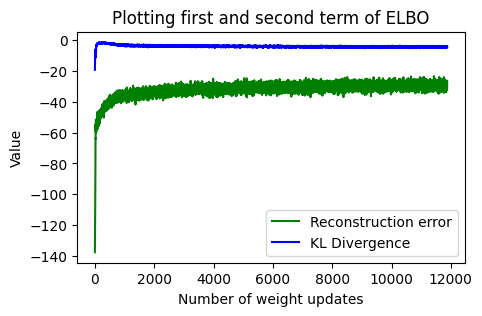

In [294]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'green', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'blue', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

## Compare reconstruction error on training vs validation data.
**Purpose of the plot:** This plot helps us monitor the training process and check for overfitting.

Ideally, you want to see both the training and validation log likelihoods increasing (since higher log likelihood indicates better reconstruction) and staying close together. This indicates that the model is improving its performance on both the seen (training) and unseen (validation) data.



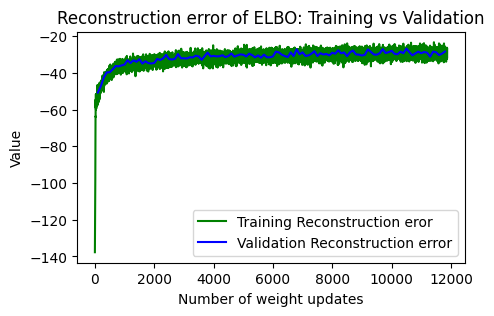

In [295]:
vestl = [x.cpu().detach() for x in vestl]

plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'green', label='Training Reconstruction eror')

plt.plot(update, vestl, 'blue', label='Validation Reconstruction error')
plt.title('Reconstruction error of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

## Visualizing input and output from the VAE from train and test dataset.
**Purpose of the plot:** evaluate the VAE's reconstruction ability for the first (or specific for CVAE) digit.

For CVAE, select a digit you want to generate.

In [296]:
# Choose the digit you want to generate
digit_of_choice = 1  # Example: Generate a '5'

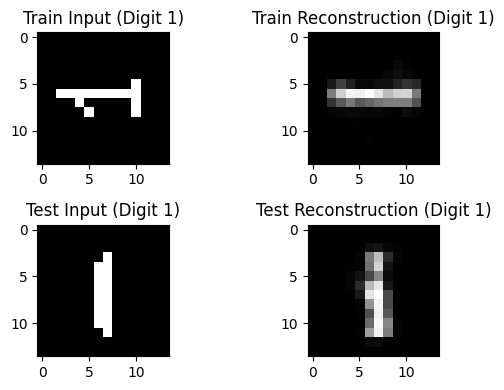

In [297]:
model.eval()

# Set up the figure for plotting
fig, axarr = plt.subplots(2, 2, figsize=(6, 4))  # 2 rows (train/test), 2 columns (input/output)

if preference != 1:
  # Train data
  train_data, _ = next(iter(trainloader))
  train_data = train_data.to(device)
  train_recon, _, _ = model(train_data[0])  # Get reconstruction for the first image in the batch
  train_recon = train_recon[0].reshape((image_length, image_length))

  # Plot train data
  axarr[0, 0].imshow(train_data[0].cpu().detach().numpy(), cmap='gray')  # Input
  axarr[0, 0].set_title('Train Input')
  axarr[0, 1].imshow(train_recon.cpu().detach().numpy(), cmap='gray')  # Output
  axarr[0, 1].set_title('Train Reconstruction')

  # Test data
  test_data, _ = next(iter(testloader))
  test_data = test_data.to(device)
  test_recon, _, _ = model(test_data[0])  # Get reconstruction for the first image in the batch
  test_recon = test_recon[0].reshape((image_length, image_length))

  # Plot test data
  axarr[1, 0].imshow(test_data[0].cpu().detach().numpy(), cmap='gray')  # Input
  axarr[1, 0].set_title('Test Input')
  axarr[1, 1].imshow(test_recon.cpu().detach().numpy(), cmap='gray')  # Output
  axarr[1, 1].set_title('Test Reconstruction')

else:
  # Train data
  train_data, train_labels = next(iter(trainloader))
  train_data, train_labels = train_data.to(device), train_labels.to(device)

  # Find an image with the desired digit in the batch
  indices = (train_labels == digit_of_choice).nonzero(as_tuple=True)[0]

  if len(indices) > 0:
    label = torch.tensor([digit_of_choice]).to(device)
    one_hot_label = F.one_hot(label, num_classes=10).float().to(device)
    train_recon, _, _ = model(train_data[indices[0]].unsqueeze(0), one_hot_label)
    train_recon = train_recon[0].reshape((image_length, image_length))

    # Plot train data
    axarr[0, 0].imshow(train_data[indices[0]].cpu().detach().numpy(), cmap='gray')
    axarr[0, 0].set_title(f'Train Input (Digit {digit_of_choice})')
    axarr[0, 1].imshow(train_recon.cpu().detach().numpy(), cmap='gray')
    axarr[0, 1].set_title(f'Train Reconstruction (Digit {digit_of_choice})')

  # Test data
  test_data, test_labels = next(iter(testloader))
  test_data, test_labels = test_data.to(device), test_labels.to(device)

  # Find an image with the desired digit in the batch
  indices = (test_labels == digit_of_choice).nonzero(as_tuple=True)[0]
  if len(indices) > 0:
      # print(train_data[indices[0]].unsqueeze(0).shape)
      # print(torch.tensor([digit_of_choice]).shape)
      label = torch.tensor([digit_of_choice]).to(device)
      one_hot_label = F.one_hot(label, num_classes=10).float().to(device)
      # print(one_hot_label.shape)
      test_recon, _, _ = model(test_data[indices[0]].unsqueeze(0), one_hot_label)
      test_recon = test_recon[0].reshape((image_length, image_length))

      # Plot test data
      axarr[1, 0].imshow(test_data[indices[0]].cpu().detach().numpy(), cmap='gray')
      axarr[1, 0].set_title(f'Test Input (Digit {digit_of_choice})')
      axarr[1, 1].imshow(test_recon.cpu().detach().numpy(), cmap='gray')
      axarr[1, 1].set_title(f'Test Reconstruction (Digit {digit_of_choice})')


plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Synthesizing new MNIST images from a standard Gaussian distribution.
**Purpose of the plot:**  explore and evaluate the capabilities of our (C)VAE. Visualize the learned latent space and generate new images.

For VAE generate a sequence of 10 random digits. For CVAE, generate all digits in 0-9.

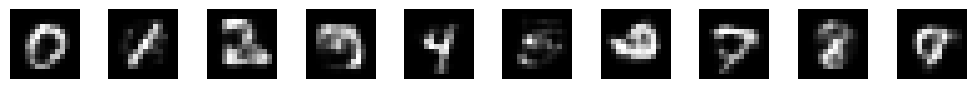

In [298]:
generated_images = []  # List to store generated images

if preference != 1:  # VAE - Generate random images
  for i in range(10):  # Generate 10 images
    x = np.random.normal(0, 1, 8)  # Sample from latent space
    x = x.astype(np.float32)
    x = torch.from_numpy(x).to(device)

    recon = model.decoder(x)  # Decode the latent vector
    generated_images.append(recon.reshape((image_length, image_length)))

elif preference == 1:  # CVAE - Generate 0-9 sequence
  for digit in range(10):
    # Create a label for the desired digit
    label = torch.tensor([digit]).to(device)
    # One-hot encode the label (if required by your model)
    label = F.one_hot(label, num_classes=10).float().to(device)

    x = np.random.normal(0, 1, 8)  # Sample from latent space
    x = x.astype(np.float32)
    x = torch.from_numpy(x).to(device)

    # add dimension to x
    recon = model.decoder(x.unsqueeze(0), label)
    generated_images.append(recon.reshape((image_length, image_length)))

fig, axarr = plt.subplots(1, 10, figsize=(10, 1))  # 1 row, 10 columns
for i, image in enumerate(generated_images):
  axarr[i].imshow(image.detach().cpu().numpy(), cmap='gray')
  axarr[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## VAE interpretability.